## **Chuẩn bị**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# imports needed for CNN
import time
import csv
import cv2
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils


Using TensorFlow backend.


## Load data

In [0]:
# Load the data
def load_data(data_dir, num_per_class):

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    
    directories.sort()
    print(directories)
    
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    lbnames = []
    
    category = 0
    for d in directories:
        lbnames.append(d)

        if(category % 5 == 0):
          print('Category', category,d)
          
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".jpg")]
        
        # adding an early stop for sake of speed
        stop = 0
        for f in file_names:
            img = cv2.imread(f)
            # imresize = cv2.resize(img, (30, 30))
            images.append(img)
            labels.append(category)
            stop += 1
            # remove this to use full data set
            if stop > num_per_class:
                break
            #end early stop
            
        category += 1

    return images, labels, lbnames

In [0]:
# show sample image
def showSampleImg(cat, url):
  fig = plt.figure(figsize=(8, 8))
  
  catNm = lbnames[cat]
  print(catNm)
  
  catFolder = url + '/' + catNm
  file_names = [os.path.join(catFolder, f)
                      for f in os.listdir(catFolder)
                      if f.endswith(".jpg")]
        
  # adding an early stop for sake of speed
  stop = 0
  for f in file_names:
    if(stop == 5):
      break

    stop = stop + 1
    fig.add_subplot(1, 5, stop)
    img = cv2.imread(f)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
 


In [0]:
# Image folder
train_dir = '/content/gdrive/My Drive/Classroom/fruit/Training'
test_dir = '/content/gdrive/My Drive/Classroom/fruit/Test'

## **TODO: Visualize input data**

4131
(100, 100, 3)


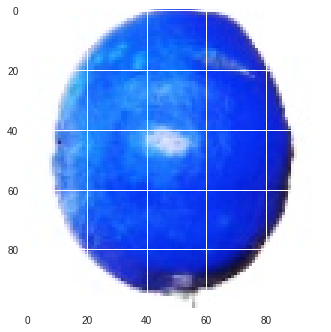

In [0]:
# confirm that we have the data
print(len(X))
print(X[0].shape)
plt.imshow(X[0])

## Tunning CNN model

In [0]:
# load small data for tunning CNN model
stime = time.time()
#X_train, y_train, lbnames = load_data(train_dir, 100)
X, y, lbnames = load_data(test_dir, 10000)
second = time.time() - stime;
print("load data finished in %dm %ds" % (int(second/60), int(second%60)))

Category: 0
Category: 5
Category: 10
Category: 15
Category: 20
Category: 25
Category: 30
Category: 35
Category: 40
Category: 45
Category: 50
Category: 55
Category: 60
Category: 65
Category: 70
Category: 75
Category: 80
load data finished in 0m 59s


In [0]:
# Chia Train - test
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=0)


Normalize the data and hot encode outputs

In [0]:
# normalize inputs from 0-255 and 0.0-1.0
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9713, 100, 100, 3)
(4164, 100, 100, 3)
(9713, 81)
(4164, 81)


Define f1 score for CNN metrics

In [0]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## 1ST CNN Model

* Input: 100x100x3 
* Conv: 8 3x3            --> 100x100x8
* Drop: 0.2 
* Conv: 8 3x3            --> 100x100x8
* Flat                          --> 80k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81









In [0]:
def cnnModel1(num_classes):
    # Create the model
    model = Sequential()
    model.add(Convolution2D(8, 3, 3, input_shape=(100, 100, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 30  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[f1])
    
    print(model.summary())
    return model

# create our CNN model
model1 = cnnModel1(81)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
dropout_30 (Dropout)         (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 100, 100, 8)       584       
_________________________________________________________________
flatten_14 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               40960512  
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 81)                41553     
Total para

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(100, 100,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  


## 2ND CNN Model

* Input: 100x100x3 
* Conv: 8 3x3            --> 100x100x8
* Drop: 0.2 
* Conv: 8 3x3            --> 100x100x8
* Drop: 0.2 
* Conv: 8 3x3            --> 100x100x8
* Flat                          --> 80k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81








In [0]:
def cnnModel2(num_classes):
    # Create the model
    model = Sequential()
    model.add(Convolution2D(8, 3, 3, input_shape=(100, 100, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 30  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[f1])
    
    print(model.summary())
    return model

# create our CNN model
model2 = cnnModel2(81)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(100, 100,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
dropout_27 (Dropout)         (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 100, 100, 8)       584       
_________________________________________________________________
dropout_28 (Dropout)         (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 100, 100, 8)       584       
_________________________________________________________________
flatten_13 (Flatten)         (None, 80000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               40960512  
__________

## 3RD CNN Model

* Input: 100x100x3 
* Conv: 8 3x3            --> 100x100x8
* Drop: 0.2 
* Conv: 8 3x3            --> 100x100x8
* MP: 2x2 --> 50x50x8
* Flat                          --> 20k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81









In [0]:
def cnnModel3(num_classes):
    # Create the model
    model = Sequential()
    model.add(Convolution2D(8, 3, 3, input_shape=(100, 100, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 30  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[f1])
    
    print(model.summary())
    return model

# create our CNN model
model3 = cnnModel3(81)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 100, 100, 8)       224       
_________________________________________________________________
dropout_25 (Dropout)         (None, 100, 100, 8)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 100, 100, 8)       584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 20000)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               10240512  
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(100, 100,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':


## 4TH CNN Model

* Input: 100x100x3 
* Conv: 16 3x3            --> 100x100x16
* Drop: 0.2 
* Conv: 16 3x3            --> 100x100x16
* MP: 2x2 --> 50x50x16
* Flat                          --> 40k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81









In [7]:
def cnnModel4(num_classes):
    # Create the model
    model = Sequential()
    model.add(Convolution2D(16, 3, 3, input_shape=(100, 100, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(16, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 30  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[f1])
    
    print(model.summary())
    return model

# create our CNN model
model4 = cnnModel4(81)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               20480512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(100, 100,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':


## 5TH CNN Model

* Input: 100x100x3 
* Conv: 32 3x3            --> 100x100x32
* Drop: 0.2 
* Conv: 32 3x3            --> 100x100x32
* MP: 2x2 --> 50x50x32
* Flat                          --> 80k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81









In [0]:
def cnnModel5(num_classes):
    # Create the model
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(100, 100, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs = 30  # >>> should be 25+
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[f1])
    
    print(model.summary())
    return model

# create our CNN model
model5 = cnnModel5(81)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               40960512  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(100, 100,..., activation="relu", padding="same", kernel_constraint=<keras.con...)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", kernel_constraint=<keras.con...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':


## Fit and run the model

In [0]:
his1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=64)
# Final evaluation of the model
# scores1 = model1.evaluate(X_test, y_test, verbose=0)
# print("f1: %.2f%%" % (scores1[1]*100))

Train on 9713 samples, validate on 4164 samples
Epoch 1/15
9713/9713 [==============================] - 12s 1ms/step - loss: 0.0072 - f1: 0.9964 - val_loss: 0.0226 - val_f1: 0.9934
Epoch 2/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0061 - f1: 0.9967 - val_loss: 0.0221 - val_f1: 0.9933
Epoch 3/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0074 - f1: 0.9966 - val_loss: 0.0213 - val_f1: 0.9933
Epoch 4/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0072 - f1: 0.9967 - val_loss: 0.0211 - val_f1: 0.9935
Epoch 5/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0081 - f1: 0.9960 - val_loss: 0.0221 - val_f1: 0.9934
Epoch 6/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0073 - f1: 0.9967 - val_loss: 0.0230 - val_f1: 0.9935
Epoch 7/15
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0068 - f1: 0.9965 - val_loss: 0.0238 - val_f1: 0.9939
Epoch 8/15
9713/9713 

In [0]:
his2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)
# Final evaluation of the model
# scores2 = model2.evaluate(X_test, y_test, verbose=0)
# print("f1: %.2f%%" % (scores2[1]*100))


Train on 9713 samples, validate on 4164 samples
Epoch 1/15
  64/9713 [..............................] - ETA: 16s - loss: 0.0065 - f1: 1.0000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


9713/9713 [==============================] - 14s 1ms/step - loss: 0.0063 - f1: 0.9968 - val_loss: 0.0147 - val_f1: 0.9945
Epoch 2/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0065 - f1: 0.9969 - val_loss: 0.0135 - val_f1: 0.9947
Epoch 3/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0064 - f1: 0.9965 - val_loss: 0.0134 - val_f1: 0.9947
Epoch 4/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0069 - f1: 0.9966 - val_loss: 0.0139 - val_f1: 0.9950
Epoch 5/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0065 - f1: 0.9964 - val_loss: 0.0135 - val_f1: 0.9947
Epoch 6/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0064 - f1: 0.9965 - val_loss: 0.0140 - val_f1: 0.9946
Epoch 7/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0064 - f1: 0.9969 - val_loss: 0.0139 - val_f1: 0.9947
Epoch 8/15
9713/9713 [==============================] - 14s 1ms/step - loss: 0.0

In [0]:
his3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)
# Final evaluation of the model
# scores3 = model3.evaluate(X_test, y_test, verbose=0)
# print("f1: %.2f%%" % (scores3[1]*100))


Train on 9713 samples, validate on 4164 samples
Epoch 1/15
 192/9713 [..............................] - ETA: 7s - loss: 0.0090 - f1: 0.9948

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


9713/9713 [==============================] - 7s 712us/step - loss: 0.0094 - f1: 0.9953 - val_loss: 0.0131 - val_f1: 0.9942
Epoch 2/15
9713/9713 [==============================] - 7s 702us/step - loss: 0.0096 - f1: 0.9955 - val_loss: 0.0126 - val_f1: 0.9945
Epoch 3/15
9713/9713 [==============================] - 7s 703us/step - loss: 0.0087 - f1: 0.9959 - val_loss: 0.0152 - val_f1: 0.9938
Epoch 4/15
9713/9713 [==============================] - 7s 696us/step - loss: 0.0080 - f1: 0.9970 - val_loss: 0.0131 - val_f1: 0.9940
Epoch 5/15
9713/9713 [==============================] - 7s 697us/step - loss: 0.0081 - f1: 0.9962 - val_loss: 0.0125 - val_f1: 0.9939
Epoch 6/15
9713/9713 [==============================] - 7s 700us/step - loss: 0.0083 - f1: 0.9957 - val_loss: 0.0136 - val_f1: 0.9940
Epoch 7/15
9713/9713 [==============================] - 7s 699us/step - loss: 0.0087 - f1: 0.9961 - val_loss: 0.0138 - val_f1: 0.9939
Epoch 8/15
9713/9713 [==============================] - 7s 698us/step - l

In [0]:
his4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=30, batch_size=64)
# Final evaluation of the model
# scores4 = model4.evaluate(X_test, y_test, verbose=0)
# print("f1: %.2f%%" % (scores4[1]*100))


Train on 9713 samples, validate on 4164 samples
Epoch 1/30
 128/9713 [..............................] - ETA: 12s - loss: 6.7521e-04 - f1: 1.0000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


9713/9713 [==============================] - 11s 1ms/step - loss: 0.0065 - f1: 0.9964 - val_loss: 0.0105 - val_f1: 0.9950
Epoch 2/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0066 - f1: 0.9967 - val_loss: 0.0111 - val_f1: 0.9951
Epoch 3/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0060 - f1: 0.9969 - val_loss: 0.0101 - val_f1: 0.9952
Epoch 4/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0064 - f1: 0.9963 - val_loss: 0.0107 - val_f1: 0.9953
Epoch 5/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0067 - f1: 0.9965 - val_loss: 0.0104 - val_f1: 0.9948
Epoch 6/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0062 - f1: 0.9970 - val_loss: 0.0108 - val_f1: 0.9947
Epoch 7/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0063 - f1: 0.9968 - val_loss: 0.0101 - val_f1: 0.9952
Epoch 8/30
9713/9713 [==============================] - 11s 1ms/step - loss: 0.0

In [0]:
his5 = model5.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=64)
# Final evaluation of the model
# scores5 = model5.evaluate(X_test, y_test, verbose=0)
# print("f1: %.2f%%" % (scores5[1]*100))


Train on 9713 samples, validate on 4164 samples
Epoch 1/15
  64/9713 [..............................] - ETA: 19s - loss: 2.7256e-04 - f1: 1.0000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


9713/9713 [==============================] - 17s 2ms/step - loss: 0.0080 - f1: 0.9965 - val_loss: 0.0116 - val_f1: 0.9945
Epoch 2/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0089 - f1: 0.9963 - val_loss: 0.0104 - val_f1: 0.9947
Epoch 3/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0080 - f1: 0.9962 - val_loss: 0.0121 - val_f1: 0.9944
Epoch 4/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0074 - f1: 0.9967 - val_loss: 0.0100 - val_f1: 0.9950
Epoch 5/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0085 - f1: 0.9956 - val_loss: 0.0113 - val_f1: 0.9945
Epoch 6/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0075 - f1: 0.9961 - val_loss: 0.0124 - val_f1: 0.9946
Epoch 7/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0076 - f1: 0.9962 - val_loss: 0.0113 - val_f1: 0.9946
Epoch 8/15
9713/9713 [==============================] - 17s 2ms/step - loss: 0.0

In [0]:
def showResult(his):
  fg, (fg1, fg2) = plt.subplots(1,2,figsize=(15,5))
  f1 = np.array(his.history['f1'])*100
  loss = np.array(his.history['loss'])*100
  val_f1 = np.array(his.history['val_f1'])*100
  val_loss = np.array(his.history['val_loss'])*100
  
  epochs = range(1, len(f1) + 1)
  
  # f1
  fg1.plot(epochs, f1, 'r', label='f1 Training')
  fg1.plot(epochs, val_f1, 'b', label='f1 Test')
  fg1.set_title('Training VS Test f1 score')
  fg1.set_xlabel('Epoch', labelpad = 15)
  fg1.set_ylabel('F1 score')
  
  # loss
  fg2.plot(epochs, loss, 'r', label='Loss Training')
  fg2.plot(epochs, val_loss, 'b', label='Loss Test')
  fg2.set_title('Training VS Test Loss score')
  fg2.set_xlabel('Epoch', labelpad = 15)
  fg2.set_ylabel('Loss')


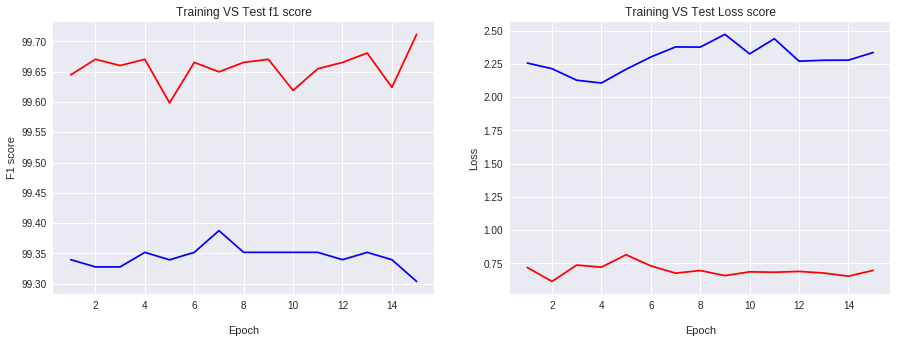

In [0]:
# Model 1 resul
showResult(his1)

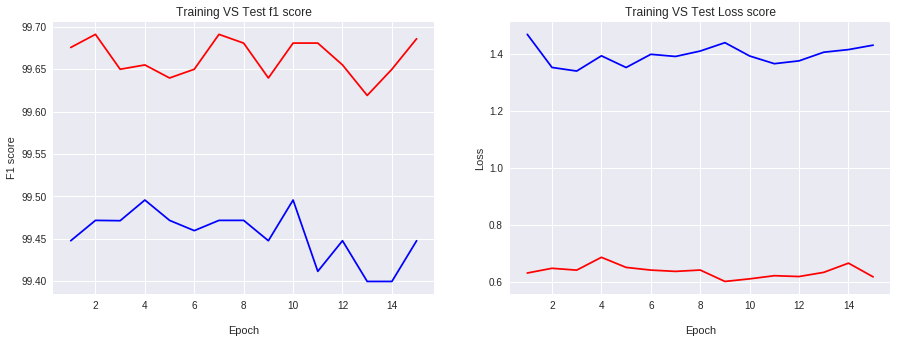

In [0]:
# Model 2 resul
showResult(his2)

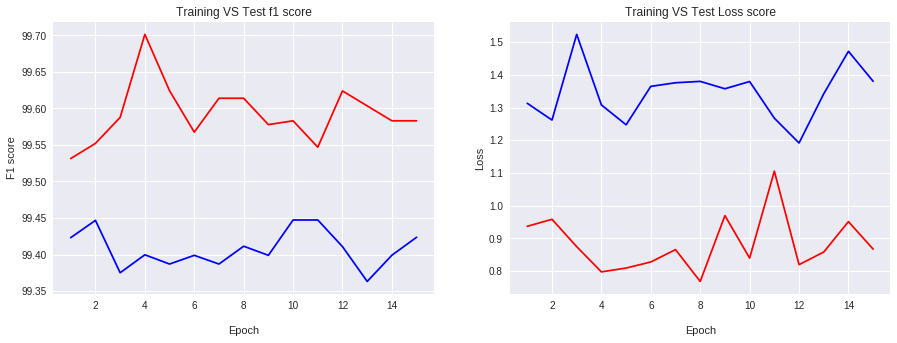

In [0]:
# Model 3 resul
showResult(his3)

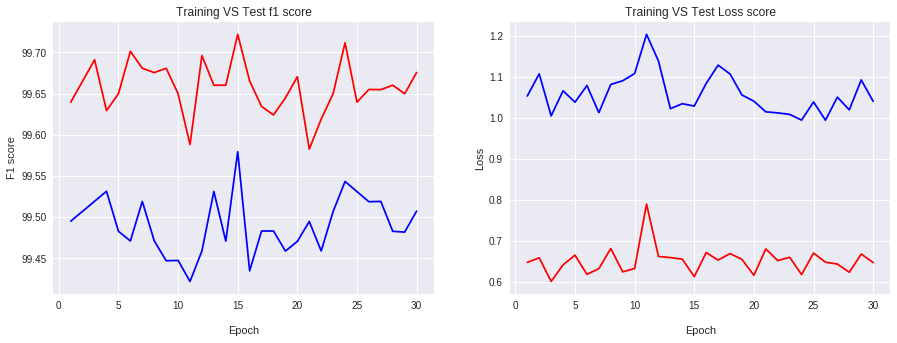

In [0]:
# Model 4 resul
showResult(his4)

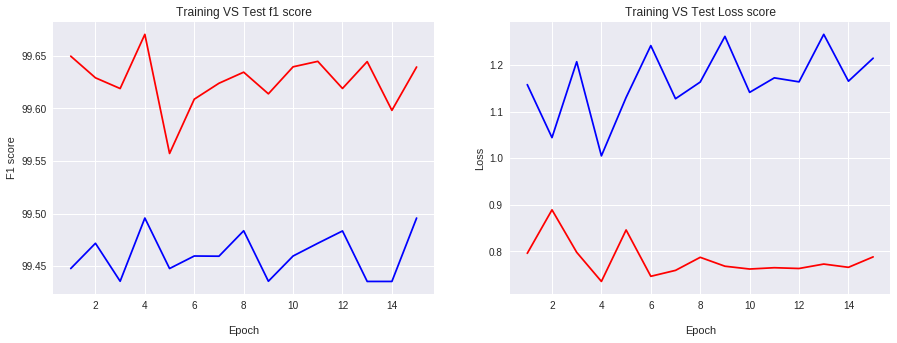

In [0]:
# Model 5 resul
showResult(his5)

In [0]:
print('Model1 - params:',model1.count_params(), "f1: %.2f%%" % (his1.history['val_f1'][-1]*100))
print('Model2 - params:',model2.count_params(), "f1: %.2f%%" % (his2.history['val_f1'][-1]*100))
print('Model3 - params:',model3.count_params(), "f1: %.2f%%" % (his3.history['val_f1'][-1]*100))
print('Model4 - params:',model4.count_params(), "f1: %.2f%%" % (his4.history['val_f1'][-1]*100))
print('Model5 - params:',model5.count_params(), "f1: %.2f%%" % (his5.history['val_f1'][-1]*100))


Model1 - params: 41002873 f1: 99.30%
Model2 - params: 41003457 f1: 99.45%
Model3 - params: 10282873 f1: 99.42%
Model4 - params: 20524833 f1: 99.51%
Model5 - params: 41012209 f1: 99.50%


## Đánh giá:
---

1. Các model đều có f1 score cao (>99%) ngay từ epoch đầu tiên
2. Model 4 có val_f1 cao nhất, đồng thời f1 gần val_f1 và loss gần val_loss nhất.

Có thể do dữ liệu tương đối thuần (kích cỡ, tỉ lệ vật/ảnh, xóa phông) -> không cần mô hình quá phức tạp.

## Kết luận: -> Chọn Model4
---

* Input: 100x100x3 
* Conv: 16 3x3            --> 100x100x16
* Drop: 0.2 
* Conv: 16 3x3            --> 100x100x16
* MP: 2x2 --> 50x50x16
* Flat                          --> 40k
* Dense 512              --> 512
* Drop: 0.2 
* Dense 81                --> 81

## Chạy lại Model 4 với full data

In [8]:
# Sử dụng lại X, y (get form Test folder)
# X_test = X
# y_test = y

# Load Training data
stime = time.time()
X_test, y_test, lbnames = load_data(test_dir, 10000)
# X_train, y_train, lbnames = load_data(train_dir, 10000)
second = time.time() - stime;
print("load data finished in %dm %ds" % (int(second/60), int(second%60)))

# # normalize inputs from 0-255 and 0.0-1.0
# X_train = np.array(X_train).astype('float32')
# X_test = np.array(X_test).astype('float32')
# X_train = X_train / 255.0
# X_test = X_test / 255.0

# # one hot encode outputs
# y_train = np.array(y_train)
# y_test = np.array(y_test)
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# his = model4.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=30, batch_size=64)

# y_prd = model4.predict(X_test, batch_size=None, verbose=0, steps=None)

# ar_ytest = np.asarray(np.matrix(y_test).argmax(1).T)[0]
# ar_yprd = np.asarray(np.matrix(y_prd).argmax(1).T)[0]

# print(classification_report(ar_ytest, ar_yprd))

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'Strawberry',

In [0]:
# store X_test for review later
X = X_test

# normalize inputs from 0-255 and 0.0-1.0
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40047, 100, 100, 3)
(13877, 100, 100, 3)
(40047, 81)
(13877, 81)


In [0]:
model4.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=30, batch_size=64)
# Final evaluation of the model
scores = model4.evaluate(X_test, y_test, verbose=0)
print("f1: %.2f%%" % (scores[1]*100))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 40047 samples, validate on 13877 samples
Epoch 1/30
40047/40047 [==============================] - 48s 1ms/step - loss: 0.9707 - f1: 0.7075 - val_loss: 0.3316 - val_f1: 0.8906
Epoch 2/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.1099 - f1: 0.9644 - val_loss: 0.2976 - val_f1: 0.9030
Epoch 3/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.0390 - f1: 0.9861 - val_loss: 0.1692 - val_f1: 0.9439
Epoch 4/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.0193 - f1: 0.9924 - val_loss: 0.1098 - val_f1: 0.9617
Epoch 5/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.0133 - f1: 0.9937 - val_loss: 0.0951 - val_f1: 0.9666
Epoch 6/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.0124 - f1: 0.9941 - val_loss: 0.1159 - val_f1: 0.9616
Epoch 7/30
40047/40047 [==============================] - 42s 1ms/step - loss: 0.0124 - f1: 0.9942 - val_loss: 0.0841 - val_f1: 0.9707
Epoch

In [0]:
y_prd = model4.predict(X_test, batch_size=None, verbose=0, steps=None)

ar_ytest = np.asarray(np.matrix(y_test).argmax(1).T)[0]
ar_yprd = np.asarray(np.matrix(y_prd).argmax(1).T)[0]

report = classification_report(ar_ytest, ar_yprd)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       164
           1       1.00      0.99      0.99       164
           2       1.00      1.00      1.00       164
           3       0.92      0.94      0.93       161
           4       0.94      1.00      0.97       164
           5       0.96      0.99      0.98       164
           6       0.99      0.96      0.98       164
           7       0.99      1.00      1.00       144
           8       1.00      1.00      1.00       166
           9       0.98      1.00      0.99       164
          10       1.00      1.00      1.00       164
          11       1.00      1.00      1.00       143
          12       1.00      1.00      1.00       166
          13       0.95      0.83      0.89       166
          14       0.99      1.00      1.00       166
          15       1.00      0.96      0.98       166
          16       1.00      1.00      1.00       164
          17       1.00    

In [0]:
X = np.array(X).astype('float32')

In [0]:
np.savetxt('/content/gdrive/My Drive/ar_ytest.txt', ar_ytest, fmt='%d')
np.savetxt('/content/gdrive/My Drive/ar_yprd.txt', ar_yprd, fmt='%d')


## Review Result

In [0]:
ar_ytest = np.loadtxt('/content/gdrive/My Drive/ar_ytest.txt')
ar_yprd = np.loadtxt('/content/gdrive/My Drive/ar_yprd.txt')

 1. Review precision thap (precission < 90%): Why notX -> X?
   - Tap class precission < 90%: Each class:
      - View 5 correct image of that Class.
      - Tap {notX_prdX}: view some
  

In [0]:
def showLowPrecission(cla):
  figx = plt.figure(figsize=(16, 8))
  
  # find not class X but predicted as X
  prdIdx = np.where(ar_yprd==cla)[0]
  falseIdx = []
  
  for idx in prdIdx:
    if ar_ytest[idx] != cla:
      falseIdx.append(idx)
  
  # view 10 sample false predict
  col = 0;
  for idx in falseIdx[-20:]:
    row = int(col/10) + 1
    col = col + 1
    figx.add_subplot(row, 10, col)
    img = X_test[idx]
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  

Cherry 1


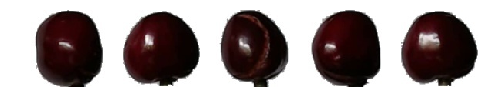

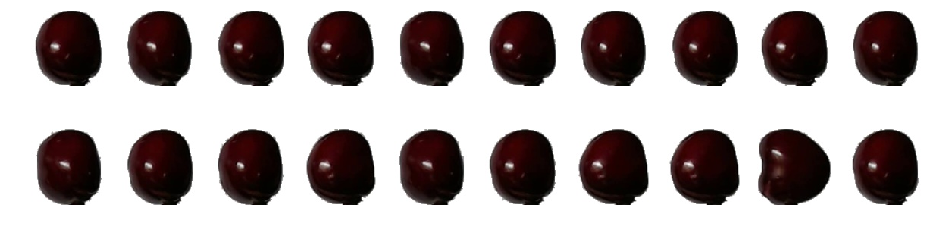

In [22]:
# review class 19
cla = 19
showSampleImg(cla, test_dir )

showLowPrecission(cla)

Cherry 2


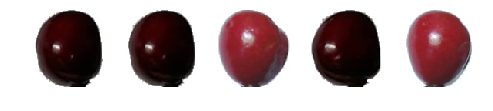

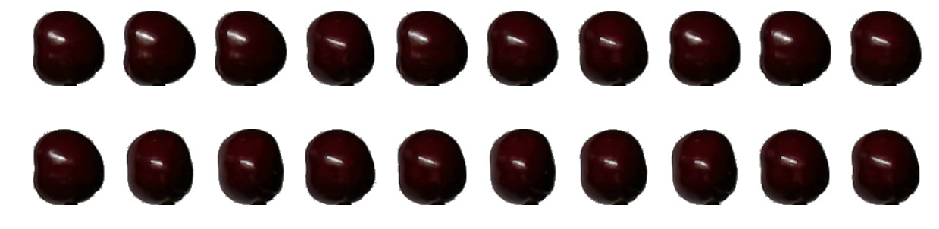

In [23]:
# review class 20
cla = 20
showSampleImg(cla, test_dir )

showLowPrecission(cla)

Nectarine


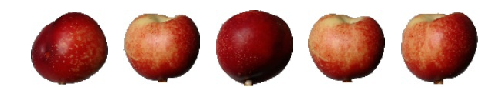

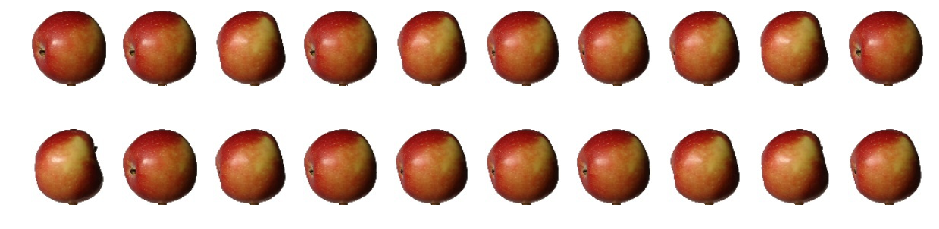

In [25]:
# review class 48
cla = 48
showSampleImg(cla, test_dir )

showLowPrecission(cla)

Peach


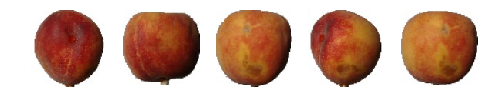

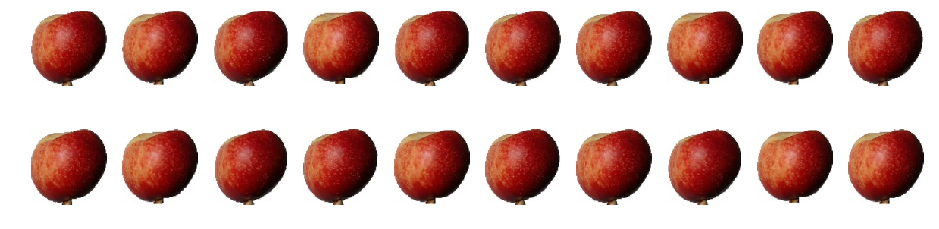

In [26]:
# review class 52
cla = 52
showSampleImg(cla, test_dir )

showLowPrecission(cla)

 2. Review Recall thap (recall < 90%): Why X -> notX?
   - Tap class recall < 90%: Each class:
      - View 5 correct image of that Class.
      - Tap {X_prdNotX}: Some x (be pridicted Y != X):
        - View x
        - View 5 correct image of Y (compare with x)
  

In [0]:
# show sample image
def showSampleImg_fig(cat, url, fig, row, nprow):
  
  catNm = lbnames[cat]
  
  catFolder = url + '/' + catNm
  file_names = [os.path.join(catFolder, f)
                      for f in os.listdir(catFolder)
                      if f.endswith(".jpg")]
        
  # adding an early stop for sake of speed
  stop = 0
  for f in file_names:
    if(stop == 5):
      break

    stop = stop + 1
    fig.add_subplot(row, 5, nprow*(row-1) + stop)
    img = cv2.imread(f)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
 


In [0]:
def showLowRecal(cla, n):
  figx = plt.figure(figsize=(16, 8))
  
  trueIdx = np.where(ar_ytest==cla)[0]
  falseIdx = []
  
  for idx in trueIdx:
    if ar_yprd[idx] != cla:
      falseIdx.append(idx)
      
  # nth false 
  idx = falseIdx[n]      
    
  # show image predited to false class
  img = X_test[idx]
  figx.add_subplot(1, 10, 1)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  

  # show false class
  falseCla = int(ar_yprd[idx])
  showSampleImg(falseCla, test_dir)


In [0]:
def getFalseClass(cla):
  trueIdx = np.where(ar_ytest==cla)[0]
  falseCla = []

  for idx in trueIdx:
    if ar_yprd[idx] != cla:
      falseCla.append(ar_yprd[idx])
  
  return falseCla

[[48 30]]
['Nectarine']
Apple Braeburn
Nectarine


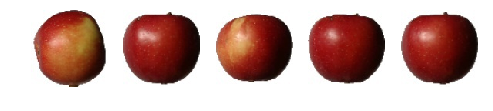

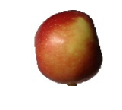

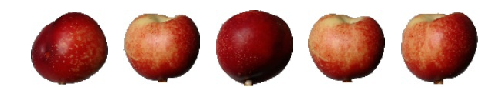

In [57]:
# review class 0
cla =  0

falseCla = getFalseClass(cla)
y = np.bincount(falseCla)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)
print(np.array(lbnames)[ii])

showSampleImg(cla, test_dir )
showLowRecal(cla,1)

[[20 50]]
['Cherry 2']
Cherry 1
Cherry 2


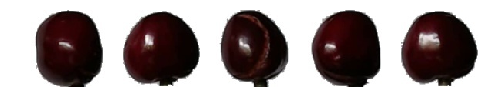

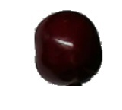

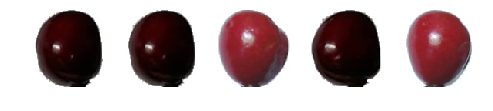

In [58]:
# review class 0
cla =  19

falseCla = getFalseClass(cla)
y = np.bincount(falseCla)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)
print(np.array(lbnames)[ii])

showSampleImg(cla, test_dir )
showLowRecal(cla,1)

[[19 66]]
['Cherry 1']
Cherry 2
Cherry 1


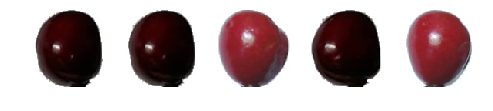

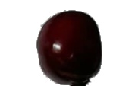

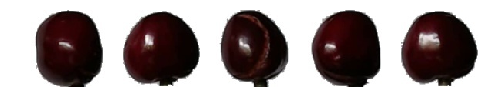

In [59]:
# review class 0
cla =  20

falseCla = getFalseClass(cla)
y = np.bincount(falseCla)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)
print(np.array(lbnames)[ii])

showSampleImg(cla, test_dir )
showLowRecal(cla,1)

[[ 5  7]
 [ 9  3]
 [52 22]]
['Apple Red 1' 'Apple Red Yellow' 'Peach']
Nectarine
Apple Red 1
Apple Red Yellow
Peach


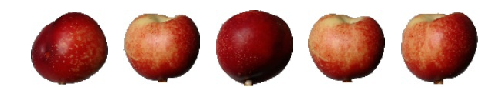

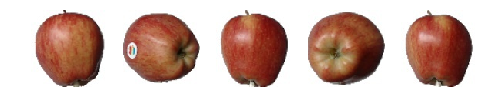

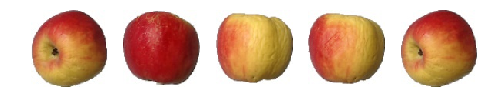

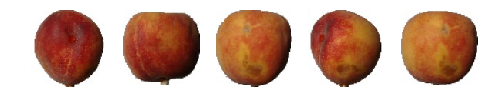

In [61]:
# review class 0
cla =  48

falseCla = getFalseClass(cla)
y = np.bincount(falseCla)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii])).T)
print(np.array(lbnames)[ii])

showSampleImg(cla, test_dir )
showSampleImg(5, test_dir )
showSampleImg(9, test_dir )
showSampleImg(52, test_dir )


# KẾT LUẬN
1. Những class có precission < 90% do hình ảnh của một số quả ở các class khác nhìn quá giống
2. Những class có recall < 90% là do bị nhầm lẫn với các class giống nhau. Ví dụ:
  * Nectarine bị nhầm với Peach
  * Cherry 1 và Cherry 2 khá giống nhau
  * Apple Braeburn bị nhầm với Nectarine

=> Loại trừ những trường hợp phân loại nhầm do giống nhau thì Mô hình có độ chính xác cao. Lý do chình là do chất lượng dữ liệu Train và Test quá tốt.
